# Importing necessay Libraries

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import OrderedDict 
import seaborn as sns
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here, we are providing transform function to provide augmenting images in train and test data

In [ ]:
train_transform = transforms.Compose([
                  transforms.RandomRotation(10),
                  transforms.RandomHorizontalFlip(),
                  transforms.Resize(227),
                  transforms.CenterCrop(227),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406],
                                       [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
                  transforms.Resize(227),
                  transforms.CenterCrop(227),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406],
                                       [0.229, 0.224, 2.225])
])

This is our CNN architecture, which has 3 Convolutional Layer and 4 fully connected layers. We also include normalization and dropout layer after each convolutional and pooling layer

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(26*26*64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)
        self.norm1 = nn.BatchNorm2d(16)
        self.norm2 = nn.BatchNorm2d(32)
        self.norm3 = nn.BatchNorm2d(64)
        self.dropOut = nn.Dropout(p=0.2)

    def forward(self, X):
        # print(X.shape)
        X = F.leaky_relu(self.conv1(X)) 
        # print(X.shape)
        X = F.max_pool2d(X, 2, 2)
        X = self.norm1(X)  
        # print(X.shape)

        X = F.leaky_relu(self.conv2(X))
        # print(X.shape)
        X = F.max_pool2d(X, 2, 2)
        X = self.norm2(X)
        # print(X.shape)

        X = F.leaky_relu(self.conv3(X))
        # print(X.shape)
        X = F.max_pool2d(X, 2, 2)
        X = self.norm3(X)
        # print(X.shape)

        X = X.view(-1, 26*26*64)
        # print(X.shape)
        X = F.leaky_relu(self.fc1(X))
        # print(X.shape)
        X = self.dropOut(X)
        # print(X.shape)
        X = F.leaky_relu(self.fc2(X))
        # print(X.shape)
        X = self.dropOut(X)
        # print(X.shape)
        X = F.leaky_relu(self.fc3(X))
        # print(X.shape)
        X = self.dropOut(X)
        # print(X.shape)
        X = self.fc4(X)
        # print(X.shape,"done")
        return F.log_softmax(X, dim=1)

Our Loss function is Cross Entropy loss and our optimizer is SGD with learning rate of 0.07 and weight decay of 0.001

In [ ]:
CNNmodel = ConvolutionalNetwork()

CNNmodel = CNNmodel.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNNmodel.parameters(), lr=0.07, weight_decay=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=43264, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

In [ ]:
!ls drive/MyDrive/covid-19/train

covid  normal  viral


In [ ]:
root = "/content/drive/MyDrive/covid-19/train"

testing_root = "/content/drive/MyDrive/covid-19/test"

train_data = datasets.ImageFolder(root, transform=train_transform)
test_data = datasets.ImageFolder(testing_root, transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['covid', 'normal', 'viral']
Training images available: 10607
Testing images available:  2273


This is visulisation of one batch of images

Label: [1 1 1 1 1 0 1 1 2 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 2 0 1 1 0 1 0 1]
Class: normal normal normal normal normal covid normal normal viral covid normal normal covid normal normal normal covid normal covid normal normal covid normal covid viral covid normal normal covid normal covid normal


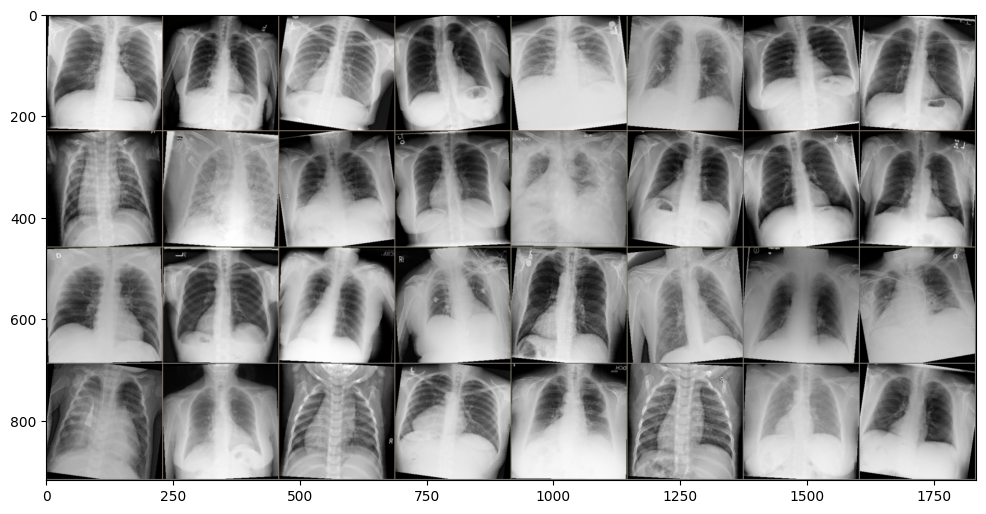

In [ ]:
# Grab the first batch of 32 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=8)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

We did 10 epochs of training. You can see that, our starting accuracy was 63% which later improved as around 94%.

In [ ]:
import time
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        b+=1
        
        # Apply the model
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4}   loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(b*128):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

  

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   10   loss: 0.54537523 accuracy:  63.984%
epoch:  0  batch:   20   loss: 0.66194063 accuracy:  67.422%
epoch:  0  batch:   30   loss: 0.46356213 accuracy:  70.234%
epoch:  0  batch:   40   loss: 0.45034280 accuracy:  71.074%
epoch:  0  batch:   50   loss: 0.52608442 accuracy:  72.875%
epoch:  0  batch:   60   loss: 0.44945616 accuracy:  73.490%
epoch:  0  batch:   70   loss: 0.42773190 accuracy:  74.297%
epoch:  0  batch:   80   loss: 0.43136913 accuracy:  74.893%
epoch:  1  batch:   10   loss: 0.32624838 accuracy:  80.547%
epoch:  1  batch:   20   loss: 0.56892580 accuracy:  79.531%
epoch:  1  batch:   30   loss: 0.38435724 accuracy:  80.469%
epoch:  1  batch:   40   loss: 0.42183158 accuracy:  80.898%
epoch:  1  batch:   50   loss: 0.50366533 accuracy:  80.734%
epoch:  1  batch:   60   loss: 0.31446898 accuracy:  81.445%
epoch:  1  batch:   70   loss: 0.38247013 accuracy:  81.942%
epoch:  1  batch:   80   loss: 0.30172360 accuracy:  82.402%
epoch:  2  batch:   10  

In [ ]:
torch.save(CNNmodel.state_dict(), 'drive/MyDrive/IP_radiography.pt')
from google.colab import files
# files.download('IP_radiography.pt')

# We are loading saved model as we don't want to train it again and again

In [ ]:
model = ConvolutionalNetwork()
model = model.to(device)
model.load_state_dict(torch.load("drive/MyDrive/IP_radiography.pt",  map_location=device))

model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=43264, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_true = []
y_pred = []
for b, (X_test, y_test) in enumerate(test_loader):
            print(b)
            # Limit the number of batches
            X_test, y_test = X_test.to(device), y_test.to(device)

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            y_pred += predicted
            y_true += y_test
            # tst_corr += (predicted == y_test).sum()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
for i in range(len(y_true)):
  y_true[i] = y_true[i].detach().cpu().numpy()
  y_pred[i] = y_pred[i].detach().cpu().numpy()

In [ ]:
cm = confusion_matrix(y_true, y_pred)

categories = ['covid', 'normal', 'viral']
cm

array([[ 419,  115,    8],
       [  64, 1445,   20],
       [   1,   11,  190]])

## Confusion Matrix

<Axes: >

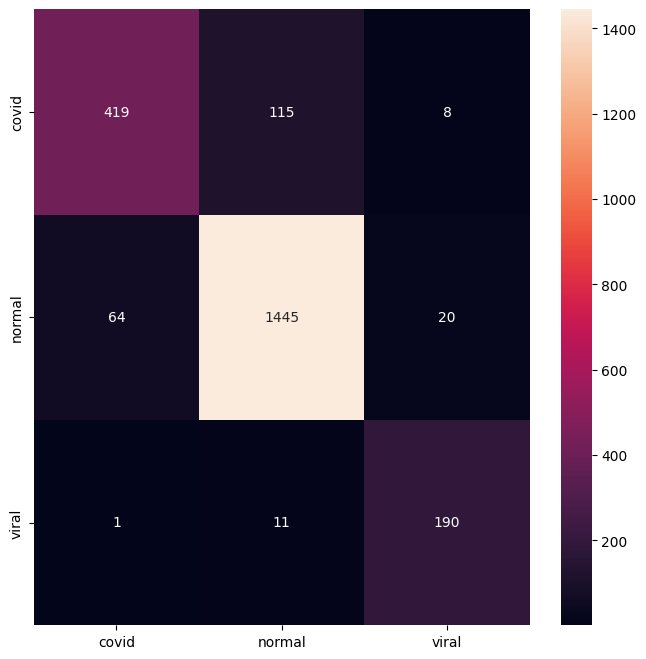

In [ ]:
df_cm = pd.DataFrame(cm, categories, categories)
plt.figure(figsize=(8,8))
sns.heatmap(df_cm, annot=True, fmt="g")

## Accuracy, Precision, Recall, and f1-score

In [ ]:
print("Accuracy of this model is:",accuracy_score(y_true, y_pred))
print("Precision of this model is:",precision_score(y_true, y_pred, average="macro"))
print("Recall of this model is:",recall_score(y_true, y_pred,  average="macro"))
print("F1-Score of this model is:",f1_score(y_true, y_pred,  average="macro"))


Accuracy of this model is: 0.9036515618125824
Precision of this model is: 0.8856861401501296
Recall of this model is: 0.8862396407152463
F1-Score of this model is: 0.8845947006105467


In [ ]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=43264, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

# Wrapped model for t-SNE

In [ ]:
class NewModel(nn.Module):
    def __init__(self, resnet, output_layers=None,*args, ):
        super().__init__(*args)
        self.output_layers = [2, 3]
        #print(self.output_layers)
        self.selected_out = OrderedDict()

        #PRETRAINED MODEL
        self.pretrained = model
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
    
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
newModel = NewModel(model)
newModel = newModel.to(device)

In [ ]:
f = 10
labels = []
outputs = []
with torch.no_grad():
  for b, (image, label) in enumerate(test_loader):

        print(b,f)
        # Apply the model
        image, label = image.to(device), label.to(device)
        _, dictionary = newModel(image)
        labels += label
        outputs += dictionary['conv3']
        f-=1


0 10
1 9
2 8
3 7
4 6
5 5
6 4
7 3
8 2
9 1
10 0
11 -1
12 -2
13 -3
14 -4
15 -5
16 -6
17 -7


In [ ]:
len(outputs)

2273

In [ ]:
for i in range(len(outputs)):
  outputs[i] = outputs[i].detach().cpu().numpy()

In [ ]:
outputs = np.asarray(outputs, dtype=np.float64)

In [ ]:
conv3 = torch.tensor(outputs)

In [ ]:
conv3.shape

torch.Size([2273, 64, 53, 53])

In [ ]:
conv3 = conv3.reshape(len(outputs), 64*53*53)
conv3 = conv3.detach().cpu().numpy()

## Implementing t-SNE with sklearn

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=100000).fit_transform(conv3)

In [ ]:
class1 = []
class2 = []
class3 = []

for i in range(len(X_embedded)):
  if(labels[i]==0):
    class1.append(X_embedded[i])
  elif(labels[i]==1):
    class2.append(X_embedded[i])
  elif(labels[i]==2):
    class3.append(X_embedded[i])

class1 = np.array(class1)
class2 = np.array(class2)
class3 = np.array(class3)

And, here we have our final output as 2D plot of last CNN layer

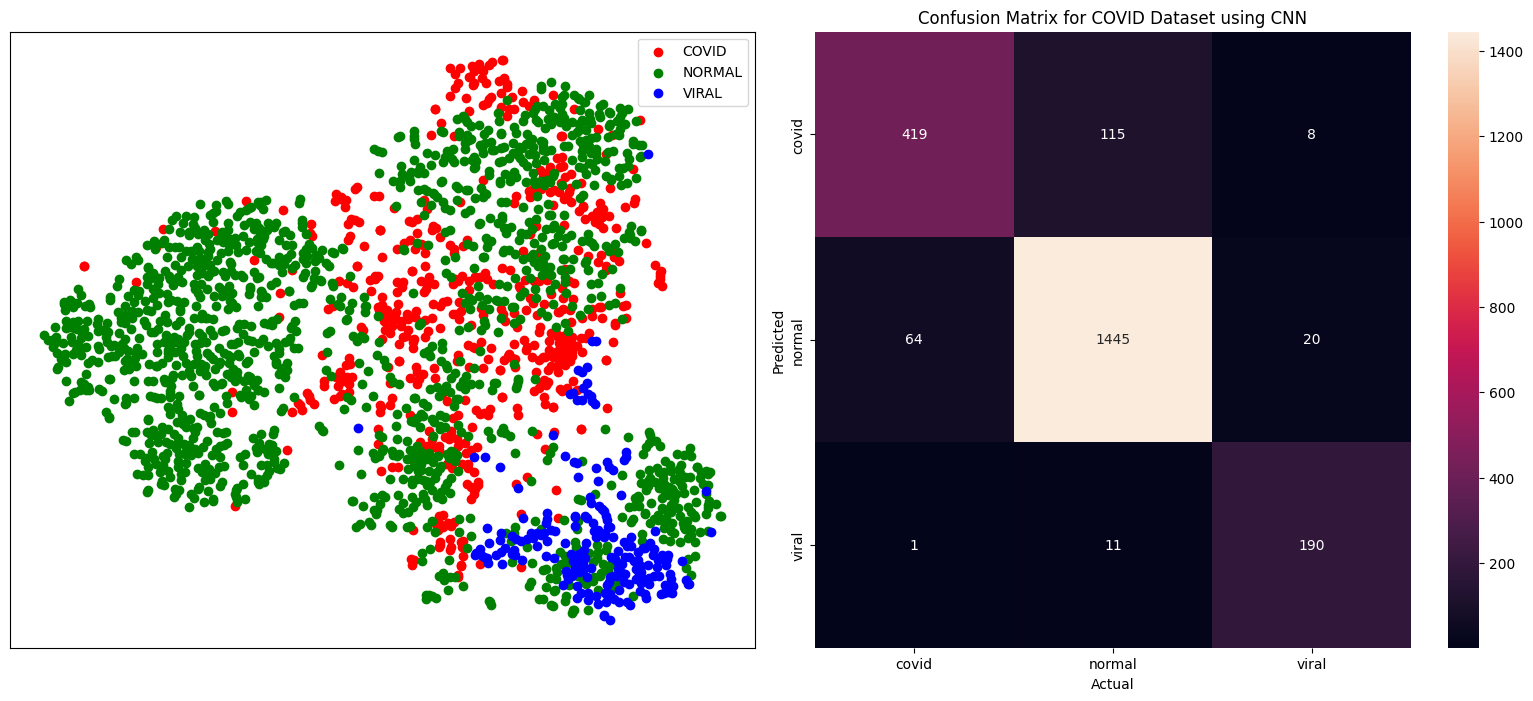

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.scatter(class1[:,0], class1[:,1], c="red", label="COVID")  
ax1.scatter(class2[:,0], class2[:,1], c="green", label="NORMAL")
ax1.scatter(class3[:,0], class3[:,1], c="blue", label="VIRAL")
ax1.legend()
# ax1.show()
ax1.set_xticks([]) 
ax1.set_yticks([]) 


sns.heatmap(df_cm, annot=True, fmt="g", ax=ax2)

ax2.set_title('Confusion Matrix for COVID Dataset using CNN')
ax2.set_xlabel("Actual")
ax2.set_ylabel("Predicted")
plt.subplots_adjust(wspace=0.08, hspace=0.04)